# WBCD dataset: Impact of the *k* parameter

On this notebook, we present python code to display figures XXXXXXXXX of the article [lien_papier].
We focused our analysis on the impact of the parameter *k* in the statistical conservation .

One propertie of the Avatar method is examined: 
 
    1 - Evolution of statistics (AUROC) accorss the value of k.

Code regarding feature selection and cancer diagnosis prediction is shown on the Python notebook `messageA_WBCD_python.ipynb`. 

## Packages import

In [1]:
# General packages required
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile

# Machine learning functions import
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Functions

In [2]:
def ml_results(clf, X_train, y_train, X_test, y_test):
    """
    perform machine learning results of the model clf

    return:
    - df_res: scores as a dataframe
    - df_roc: df of the roc curve
    - cm : cinfusion matrix
    """
    cm = pd.crosstab(y_test, clf.predict(X_test))
    TP = cm.iloc[0, 0]
    TN = cm.iloc[1, 1]
    FP = cm.iloc[0, 1]
    FN = cm.iloc[1, 0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) * 100
    specificity = TN / (TN + FP) * 100
    ppv = TP / (TP + FP) * 100
    npv = TN / (TN + FN) * 100
    auc = metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    fpr, tpr, thresholds = metrics.roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    df_roc = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})
    df_res = pd.DataFrame(
        [accuracy, sensitivity, specificity, ppv, npv, auc],
        index=["acc", "sens", "spec", "ppv", "npv", "auc"],
    )

    return df_res, df_roc, cm

In [3]:
def unique_SVM_model(
    X_train, y_train, X_test, y_test, X_test_ori, y_test_ori, order, parameters, nb_var
):
    """
    function that train a SVM model, found best parameters and return performance resutls and best parameters
    input :
        - X_train, y_train, X_test, y_test: typical datasets for training a ML model
        - order : the variables importance order
        - parameters :
        - nb_var : the number of feature selected for the model

    output :
        - best_params :parameters of the best model
        - cm: confusion matrix of the best model
        - df_res : performance of prediction results
        - df_roc: dataframe to draw ROC curve.
    """
    # train the model
    svc = SVC(probability=True)
    clf = GridSearchCV(svc, parameters, cv=5, n_jobs=11)
    clf.fit(X_train[order[0:nb_var]], y_train)
    best_params = clf.best_params_

    ### test the model
    # on avatar test
    res_avat, df_roc_avat, cm_avat = ml_results(
        clf, X_train[order[0:nb_var]], y_train, X_test[order[0:nb_var]], y_test
    )
    # on original test
    res_ori, df_roc_ori, cm_ori = ml_results(
        clf, X_train[order[0:nb_var]], y_train, X_test_ori[order[0:nb_var]], y_test_ori
    )

    return (best_params, cm_avat, res_avat, df_roc_avat, cm_ori, res_ori, df_roc_ori)

In [4]:
def preparation(df, iter, k):
    """
    small function which reshape and transform the df WBCD
    """
    df = df[df["iter_k"] == iter]
    df = df[df["k"] == k]
    df.drop(columns=["k", "id_ind", "iter_k"], axis=1, inplace=True)

    df.Class = df.Class.replace(2, 0)
    df.Class = df.Class.replace(4, 1)

    return df

## Graphical parameters

In [5]:
colors = pd.read_csv("../../color.csv", index_col = 0)
seq_k = [4, 50, 100, 150, 200, 300]

## SVM computation

This section compares prediction performance using avatar and original data.

### On Original data

For Orginal data, we performed 100 different train/test 70/30 splits datasets.  
For each split, we trained an SVM model and test our it in the test section.

Computation is time consummming ; results are saved in a csv file and can be import later.

In [6]:
compute = False

if compute : 
    import multiprocessing

    df = pd.DataFrame(columns=[0, "test"])

    file_data  = "../../datasets/"
    avatar_ref = pd.read_csv(file_data + "/WBCD/breast_cancer_wisconsin_avatarized_k20.csv")
    data = pd.read_csv(file_data + "/WBCD/breast_cancer_wisconsin.csv")
    data = data.drop("Sample_code_number", axis = 1)
    data.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'Class']
    order = ['F6', 'F3', 'F2', 'F7', 'F1', 'F8', 'F5', 'F4', 'F9']
    nb_var = 5

    data.Class = data.Class.replace(2, 0)
    data.Class = data.Class.replace(4, 1)

    map_object = map(lambda val : 2**val, list(range(-15,3)))
    gamma_list = list(map_object)
    map_object = map(lambda val : 2**val, list(range(-5,16)))
    C_list = list(map_object)
    parameters = {'kernel': ['rbf'], 'C': C_list, 'gamma' : gamma_list}

    for seed in range(100):
        # split for model 
        data_X_train_70, data_X_test_30, data_y_train_70, data_y_test_30 = train_test_split(
            data.drop("Class", axis = 1), 
            data.Class, train_size = 0.7,
            stratify = data.Class,
            random_state = seed)

        # train the model 
        svc = SVC(probability = True)
        clf_ori = GridSearchCV(svc, parameters, cv = 5, n_jobs= 11)
        clf_ori.fit(data_X_train_70[order[0:nb_var]], data_y_train_70)
        best_params = clf_ori.best_params_


        ### test the model 
        # on avatar test
        res_data, df_roc_data, cm_data = ml_results(clf_ori, data_X_train_70[order[0:nb_var]], data_y_train_70, data_X_test_30[order[0:nb_var]], data_y_test_30)
        res_data['test'] = res_data.index
        res_data.reset_index(inplace = True, drop = True)
        df = df.append(res_data)

In [7]:
# load results FOR ORGINAL DATA
df = pd.read_csv("../../datasets/results_df/original_data_perf_wbcd.csv")

### On avatars data

We repeated 10 different avatarizations for each k with  `k  = {4 -> 334 by 30}`,   
and  compute SVM models and test it.

#### Parameters

In [8]:
map_object = map(lambda val: 2 ** val, list(range(-5, 16)))
C_list = list(map_object)

map_object = map(lambda val: 2 ** val, list(range(-15, 3)))
gamma_list = list(map_object)

parameters = {"kernel": ["rbf"], "C": C_list, "gamma": gamma_list}

In [9]:
def loop_model(rep):
    """
    Function used in the parralelle computation
    """
    # Select subset df
    avatar_A = preparation(df_temp, rep, k)
    order = ["F6", "F3", "F2", "F7", "F1", "F8", "F5", "F4", "F9"]

    # split for model
    (avatar_A_X_train_70,
     avatar_A_X_test_30,
     avatar_A_y_train_70,
     avatar_A_y_test_30) = train_test_split(avatar_A.drop("Class", axis = 1),
                                            avatar_A.Class,
                                            train_size = 0.7,
                                            stratify = data.Class,
                                            random_state = 40)

    # train test the model
    start_time = time.time()
    (best_params_data_70_5,
     cm_avat_70_5,
     df_res_avat_70_5,
     df_roc_avat_70_5,
     cm_data_70_5,
     df_res_data_70_5,
     df_roc_data_70_5) = unique_SVM_model(X_train = avatar_A_X_train_70,
                                          y_train = avatar_A_y_train_70,
                                          X_test = avatar_A_X_test_30,
                                          y_test = avatar_A_y_test_30,
                                          X_test_ori = data_X_test_30,
                                          y_test_ori = data_y_test_30,
                                          order = order,
                                          parameters = parameters,
                                          nb_var = nb_feat)
    end_time = time.time()
    print("k:", k, "iter : ", rep, (end_time - start_time) / 60)

    df = pd.concat([df_res_avat_70_5, df_res_data_70_5], axis = 1).T
    df["test_type"] = ["avatar", "original"]
    df["k"] = k
    df["iter_k"] = rep

    return df

#### Loop Computation

This loop is doing different SVM models for different avatarized datasets, results were saved and load bellow. Computation is thus useless.

In [10]:
compute  = False

if compute : 
    
    # import Avatar data
    avatar_ref.Class = avatar_ref.Class.astype('category')
    zip = zipfile.ZipFile('../../datasets/WBCD/wbcd_avatarized.zip')
    namelist = zip.namelist()
    del namelist[0]

    # perform SVM models for differents k value wirh a loop
    results_list = list()
    pool_outputs = list()
    order_features_data = ['F3', 'F2', 'F6', 'F7', 'F1', 'F8', 'F5', 'F4', 'F9'] 
    nb_feat = 5

    # results_df = pd.DataFrame( columns=['k', 'iter', 'acc', "sens", 'spec', "ppv", "npv", "auc" ])
    # max_pool = 10

    start_time_total = time.time()

    for name_temp in namelist:

        # read files 
        df_temp = pd.read_csv(zip.open(name_temp))

        # reshape files
        if df_temp.columns[0] == 'Unnamed: 0' : 
            df_temp.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

        df_temp.columns = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'Class', 'k', 'id_ind', 'iter_k']
        k = np.unique(df_temp['k'])[0]

        inp = np.unique(df_temp['iter_k'])

        # modeling loop 
        for iter in inp:
            pool_outputs.append(loop_model(iter))

    # save results
    result_k = pd.concat(pool_outputs, axis = 0)

    end_time_total = time.time()
    print("/n total time : ", (end_time_total - start_time_total) / 60)

### Import avatar result data

In [11]:
result_k = pd.read_csv("../../datasets/results_df/accuracy_k_wbcd.csv")

# subset to plot only avatar train - avatar test
# (and remove avatar train, original test)
result_k = result_k[result_k["test_type"] == "avatar"]
result_k = result_k[result_k["k"] < 343]

## Result vizualisation  

We are here visualize the Area under the ROC curve (AUC) according k value, and comparing the evolution of the curve between the original data and avatar data.

In [12]:
mean = df.groupby(["test"]).aggregate(["mean", "count", "std"])

ci95_hi = []
ci95_lo = []

for i in mean.index:
    m, c, s = mean.loc[i]
    ci95_hi.append(m + 1.95 * s / math.sqrt(c))
    ci95_lo.append(m - 1.95 * s / math.sqrt(c))

mean["ci95_hi"] = ci95_hi
mean["ci95_lo"] = ci95_lo

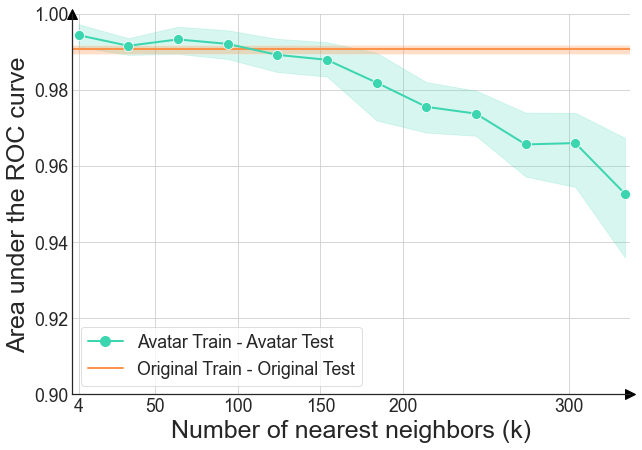

In [13]:
# Figure context
paper_rc = {"lines.linewidth": 2, "lines.markersize": 10}
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2, rc=paper_rc)
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.25
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Helvetica"]
    fig = plt.figure(figsize=(10, 7))  # create a figure object
    ax1 = fig.add_subplot()

# add original data results (mean and confidence intervals).
plt.axhline(y = mean.loc["auc", ("0", "mean")], color = colors.loc["original", "color"], linestyle = "-")

# add avatar results with confidence intervals.
sns.despine()
sns.set_style("whitegrid")
ax = sns.lineplot(
    data = result_k,
    x = "k",
    y = "auc",
    ci = 95,
    hue = "test_type",
    style = "test_type",
    err_style = "band",
    markers = True,
    dashes = False,
    estimator = "mean",
    palette = [colors.loc["avatar", "color"]]
)

# Manage style 
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.axhline(c = colors.loc["original", "color"], linestyle = "solid"))

ax.axhspan(mean.loc["auc", ("ci95_hi", "")], mean.loc["auc", ("ci95_lo", "")], facecolor = colors.loc["original", "color"], alpha = 0.3)
ax.set_xlabel("Number of nearest neighbors (k)", fontsize = 25)
ax.set_ylabel("Area under the ROC curve", fontsize = 25)
# add arrow to x axis 
ax.plot((1), (0.9), ls = "", marker = ">", ms = 10, color = "k",
        transform = ax.get_yaxis_transform(), clip_on = False)
# add arrow to y axis
ax.plot((0), (1), ls = "", marker = "^", ms = 10, color = "k",
        transform = ax.get_xaxis_transform(), clip_on = False)
ax.set(ylim = (0.90, 1), xlim = (0, 337))

plt.xticks(seq_k)

legend = plt.legend(
    loc = "lower left",
    frameon = 1,
    title = "",
    labels = ["Avatar Train - Avatar Test", "Original Train - Original Test"],
    handles = handles[:],
)

#plt.savefig("../../figure/WBCD_auc_variousK_70_30.svg", format = "svg", dpi = 600)

plt.show()